In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.spatial.distance import cdist

sns.set_style('white')
sns.set(font_scale=2)

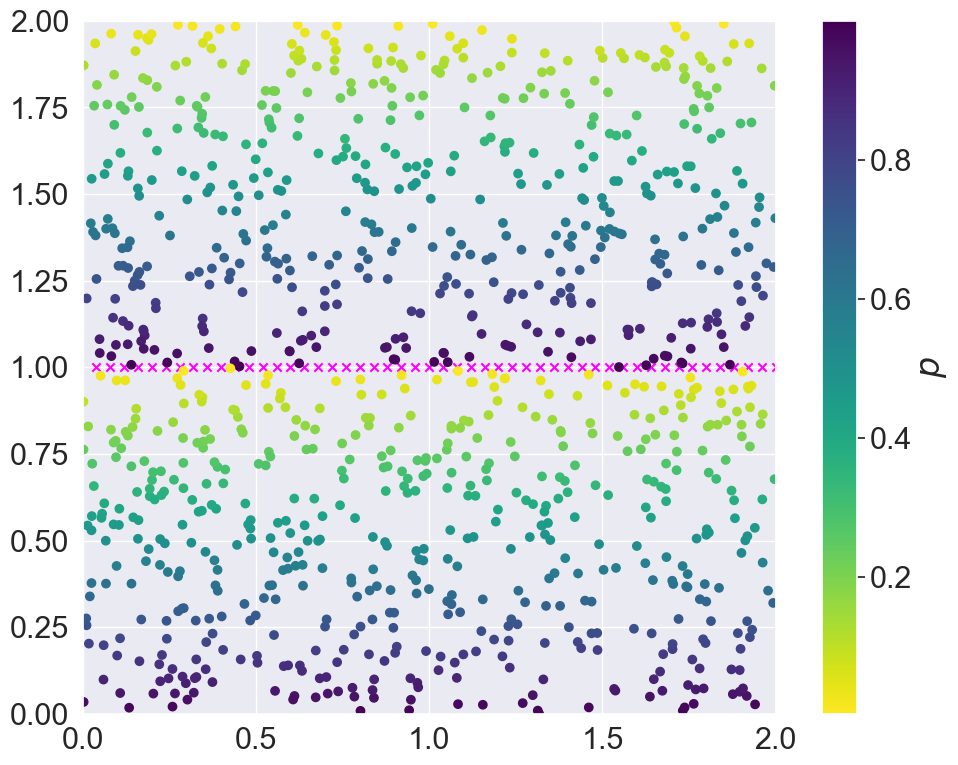

In [2]:
# Make points
l = 2
midpoint = l*0.5
maxR = l*0.5
cmap = plt.cm.viridis_r

N_X = 50
N_Y = 1000

dr = 0.01*l # dr = width of the annulus
radius_step = 0.01*l # step in the radius
PCF_radii_lower = np.arange(0, maxR, radius_step)
PCF_radii_upper = PCF_radii_lower + dr

col = cmap(0)

points_X = np.asarray([(v*l/N_X,midpoint) for v in np.linspace(1,N_X)])
points_Y = l*np.random.rand(N_Y,2)
labels_Y = (midpoint - points_Y[:,1])/midpoint
labels_Y[labels_Y < 0] = labels_Y[labels_Y < 0] + 1

plt.figure(figsize=(12,9))
plt.scatter(points_X[:,0],points_X[:,1],color=[1,0,1],marker='x')
plt.scatter(points_Y[:,0],points_Y[:,1],c=labels_Y,cmap=cmap)
plt.gca().axis('square')
plt.xlim([0,l])
plt.ylim([0,l])
plt.colorbar(label='$p$')
plt.savefig('./S4_ComparingWeightingFunctions_points.png')

# Calculate distances to nearby cells, keeping each contribution associated with the phenotype of that point
distances = cdist(points_X, points_Y, metric='euclidean')
areas = getAnnulusAreasAroundPoints(points_X, radius_step, maxR, l)

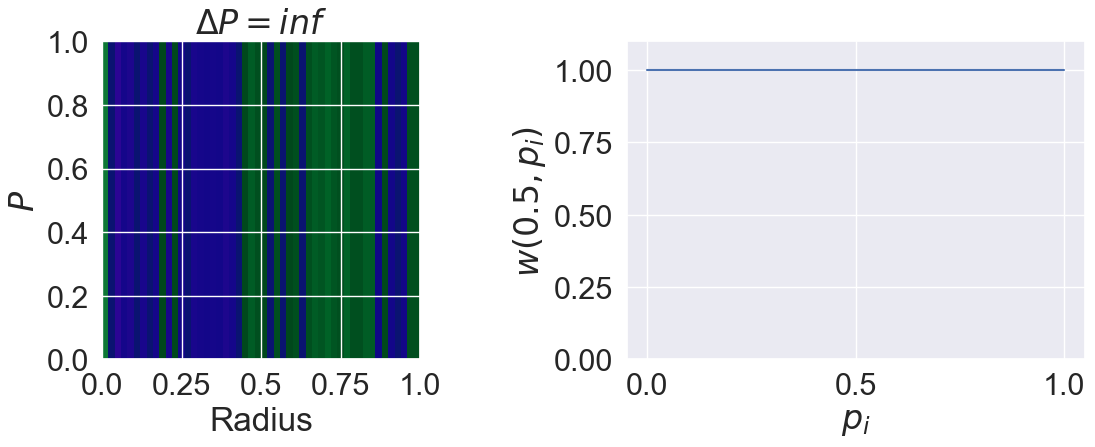

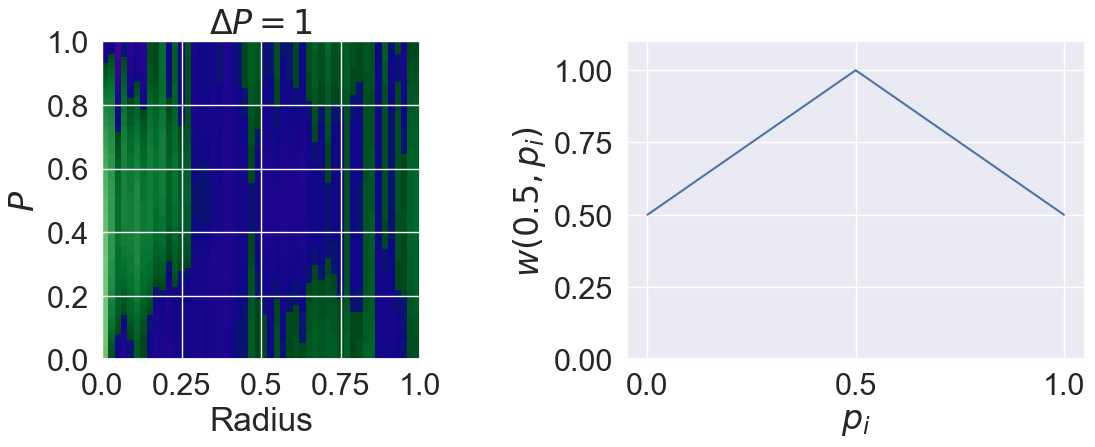

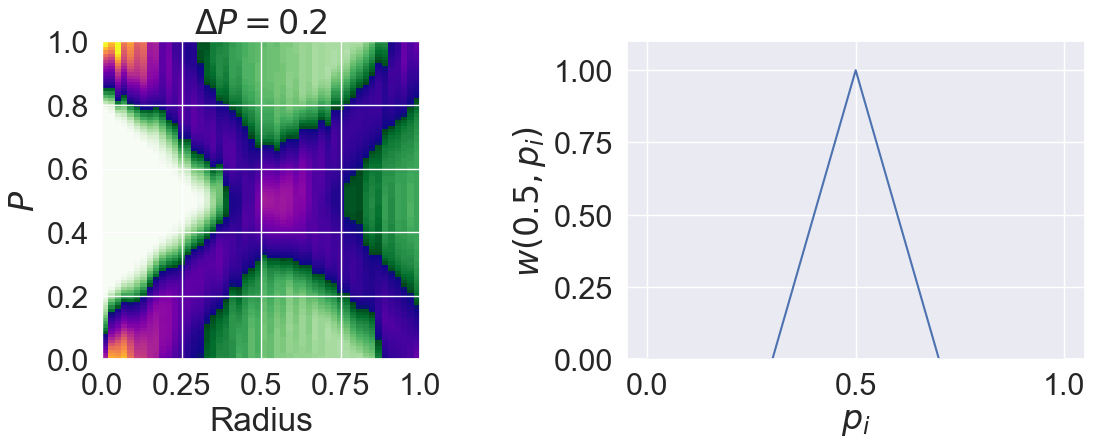

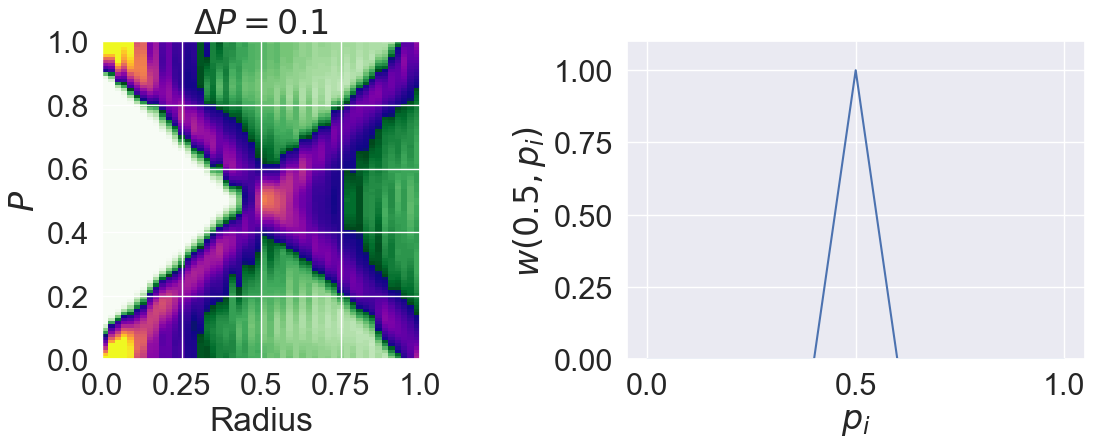

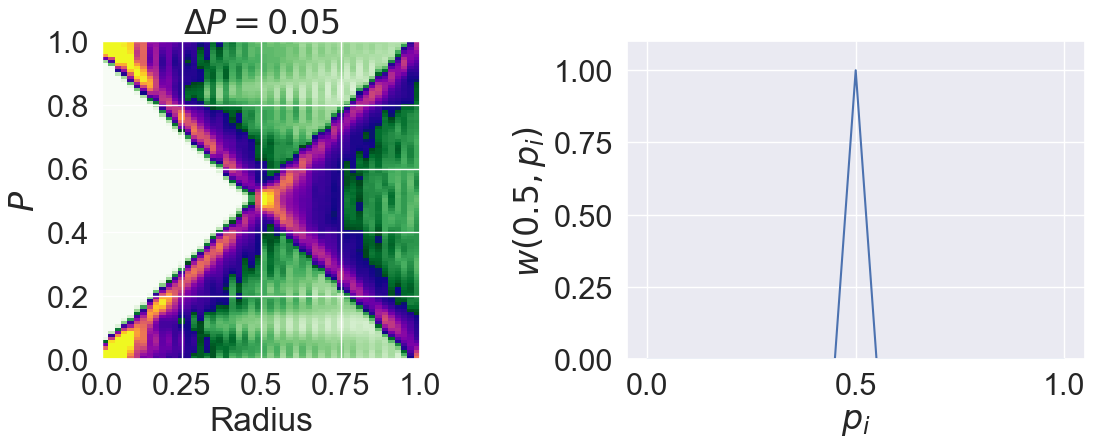

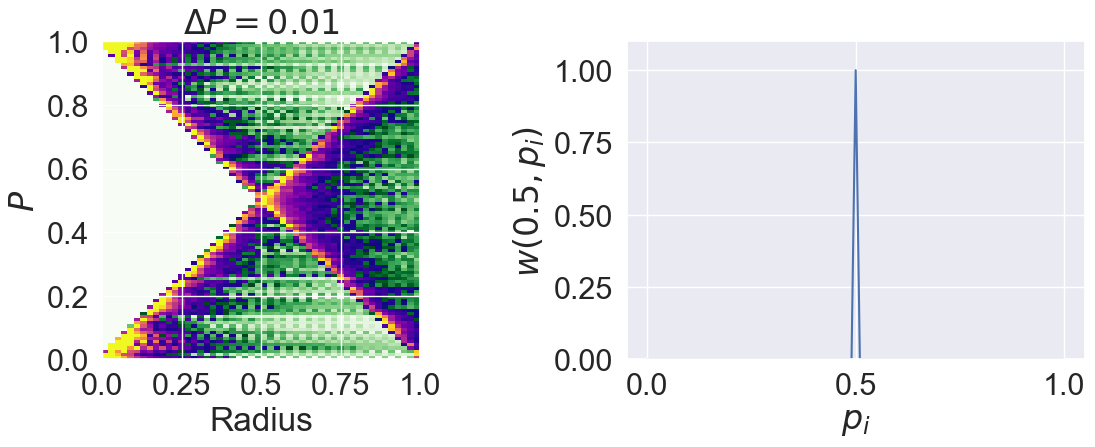

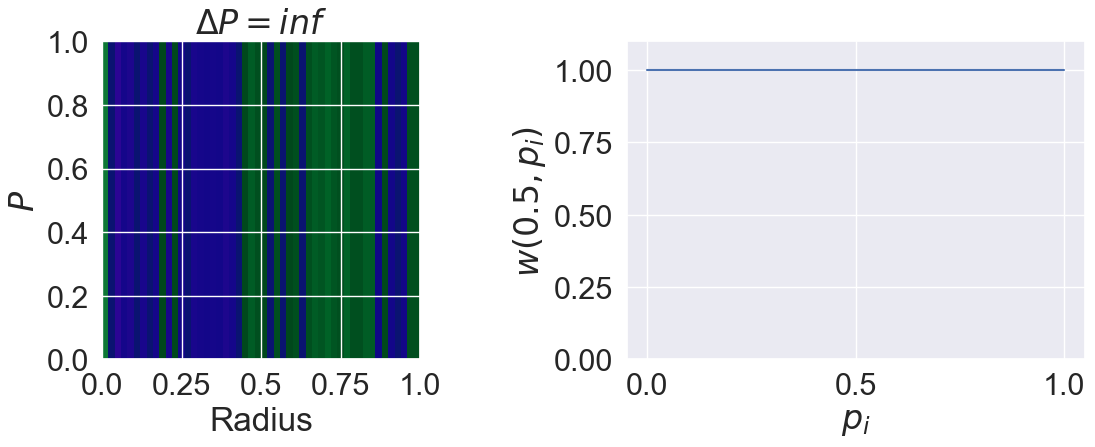

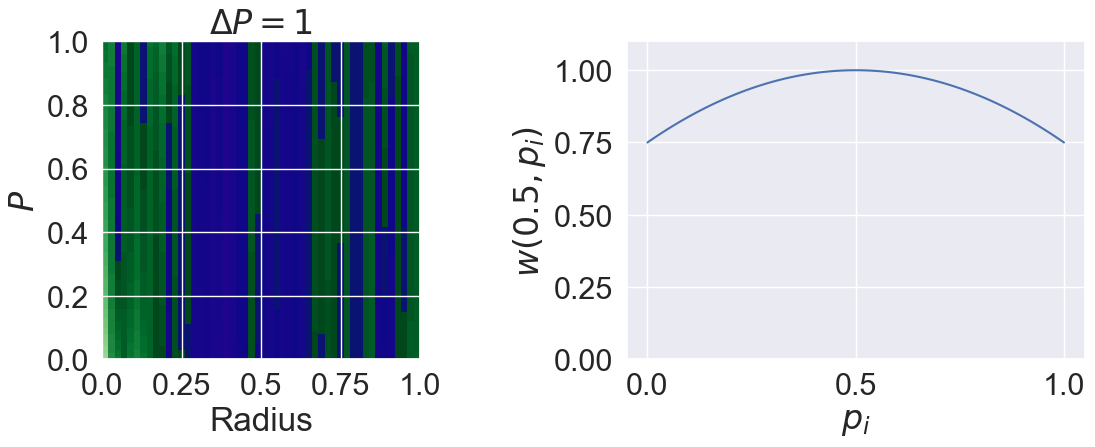

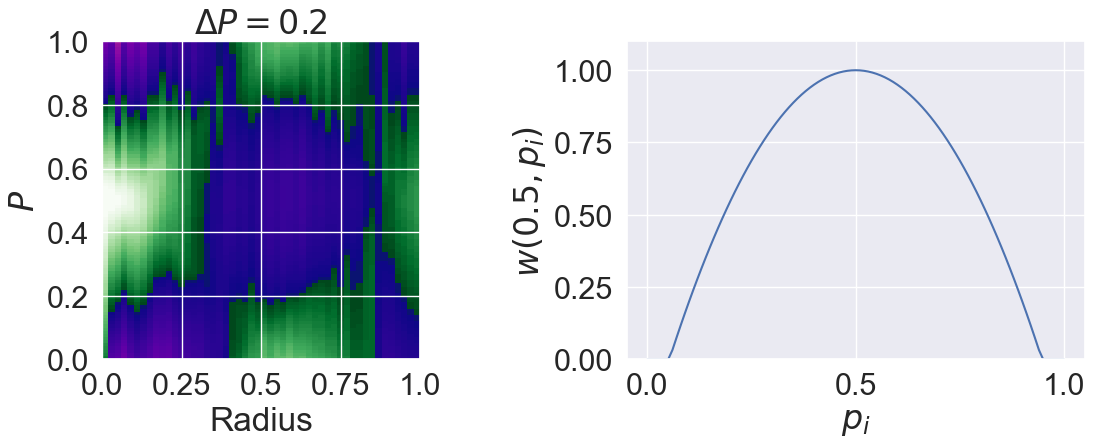

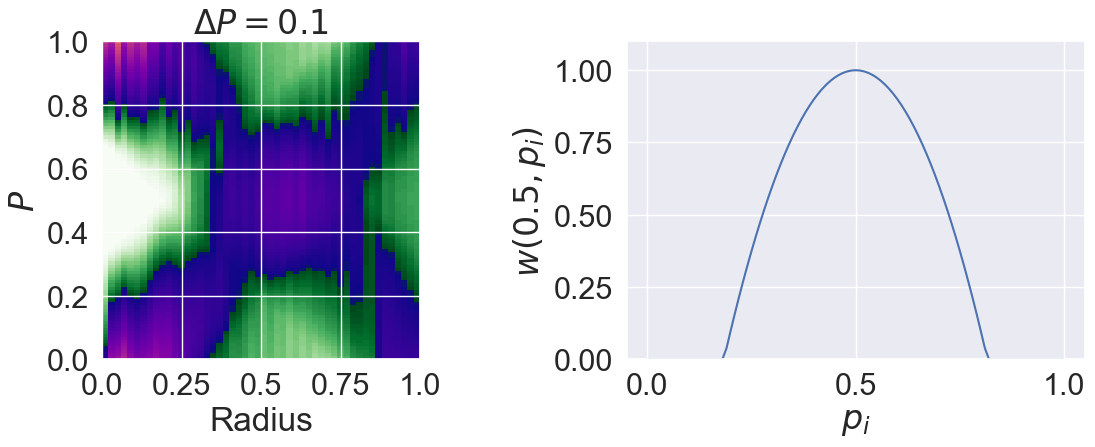

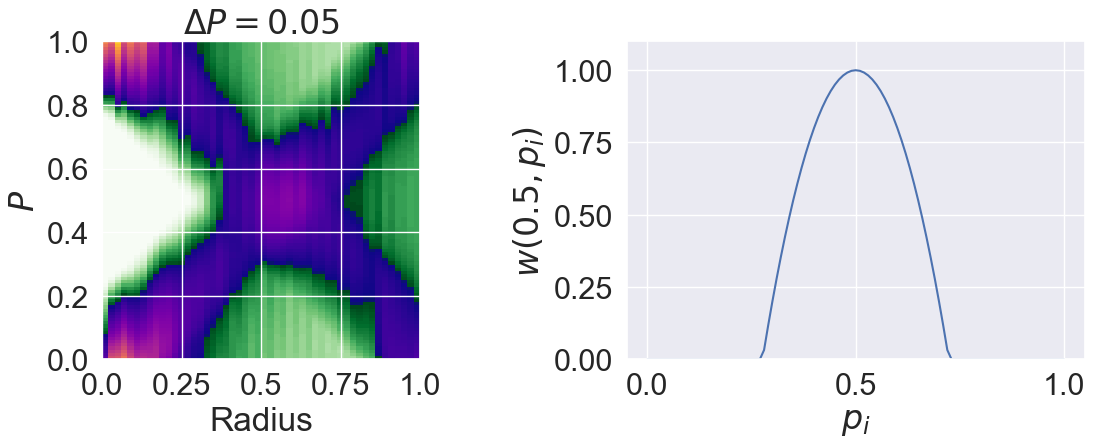

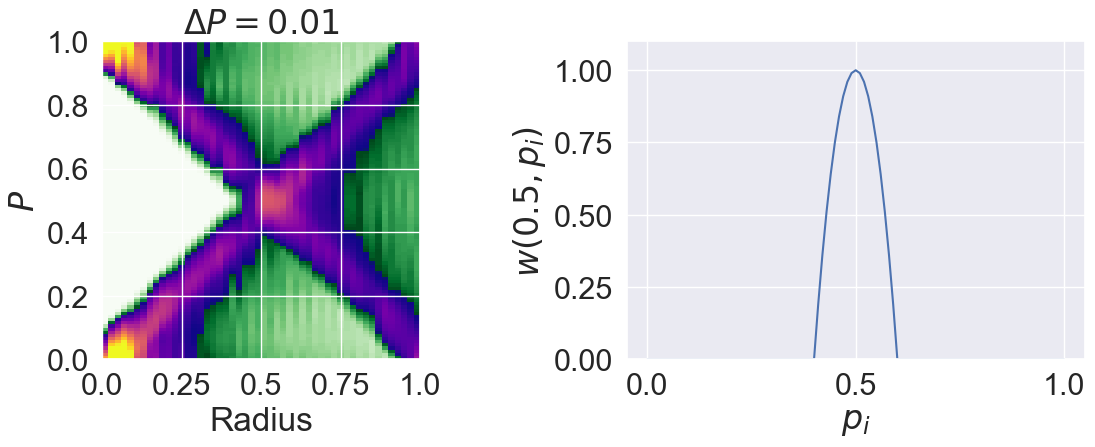

In [3]:
# Define weighting functions
def getWeights_varyingDeltaP(p,phenotypes,weightFunction,DeltaP):
    if weightFunction == 'linear':
        weights = 1-np.abs(p-phenotypes)/DeltaP
    if weightFunction == 'squares':
        weights = 1-((p-phenotypes)**2)/DeltaP
    weights = np.maximum(weights, np.zeros(np.shape(weights)))
    return weights

DeltaPs = [np.inf,1,0.2,0.1,0.05,0.01]
dP = 0.01
yRange = np.arange(0,1+dP,dP);

# Set up colormaps
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

vmin = 0
vmax = 5
one = 1/vmax

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
nCols = 1000
threshold = one*nCols

colors1 = plt.cm.Greens(np.linspace(0, 1, round(threshold)))
colors2 = plt.cm.plasma(np.linspace(0, 1, nCols - round(threshold)))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)


for weightFunction in ['linear','squares']:

    wPCFs = []
    for weightInd, DeltaP in enumerate(DeltaPs):

        # wPCF
        # Constant population: points_X
        # Varying population: points_Y (by labels_Y)

        wPCF = np.ones(shape=(len(PCF_radii_lower),len(yRange)))
        for ind, phi_Y in enumerate(yRange):
            weights_Y = getWeights_varyingDeltaP(phi_Y,labels_Y,weightFunction,DeltaP)

            totalWeight_Y = sum(weights_Y) # W_Y
            meanWeight_Y = np.mean(weights_Y) # W_Y / N_Y
            density_Y = N_Y / (l*l) # N_Y / A

            wPCF_row = np.zeros(shape=(len(PCF_radii_lower)))

            for annulus in range(len(PCF_radii_lower)):
                inner = PCF_radii_lower[annulus]
                outer = PCF_radii_upper[annulus]

                # Find pairwise distances within this radius
                distanceMask = np.logical_and((distances >= inner),(distances < outer))
                for i in range(N_X):
                    # For each blood vessel
                    # Find pairwise distances within this radius of bv i
                    fillIndices = np.where(distanceMask[i,:])[0]
                    m_i = sum(weights_Y[fillIndices]) # m_i
                    wPCF_row[annulus] = wPCF_row[annulus] + m_i*N_Y/(totalWeight_Y*density_Y*areas[i,annulus])

            wPCF[:,ind] = wPCF_row / N_X
        wPCFs.append(wPCF.transpose())


    # Plot wPCFs and kernels 
    for ax_i, DeltaP in enumerate(DeltaPs):
        fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
        axes[0].imshow(wPCFs[ax_i],origin='lower',extent=[0,1,0,1],cmap=cmap,vmin=vmin,vmax=vmax)
        axes[0].set_xlabel('Radius')
        tickProps = [0,0.25,0.5,0.75,1]
        axes[0].set_xticks(tickProps)
        axes[0].set_xticklabels([v*(PCF_radii_lower[-1]+dr) for v in tickProps])
        axes[0].set_ylabel('$P$')
        axes[0].set_title('$\Delta P = ' + str(DeltaP) + '$')

        weights = getWeights_varyingDeltaP(0.5,yRange,weightFunction,DeltaP)
        axes[1].plot(yRange, weights)
        axes[1].set_ylim([0,1.1])
        axes[1].set_xlabel('$p_i$')
        axes[1].set_ylabel('$w(0.5,p_i)$')
        plt.tight_layout()
        plt.savefig('./S4_ComparingWeightingFunctions_' + weightFunction + '_' + str(DeltaP) + '.png')